# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [70]:
data = pd.read_csv('raw_data/retail_train.csv')
item_features = pd.read_csv('raw_data/product.csv')
user_features = pd.read_csv('raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [71]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [72]:
recommender = MainRecommender(data_train_lvl_1)

In [14]:
recommender.get_als_recommendations(2375, N=200)

[871756,
 899624,
 1044078,
 844179,
 8090537,
 12262978,
 8090539,
 1000753,
 944534,
 1106523,
 832678,
 5585510,
 1092937,
 1046545,
 865456,
 883932,
 9836106,
 8090521,
 832442,
 5569230,
 1133312,
 841220,
 1051323,
 965766,
 854852,
 850102,
 999714,
 925862,
 1004906,
 1025535,
 1116376,
 835530,
 963727,
 12301839,
 973181,
 999779,
 965267,
 7441873,
 1134678,
 1100972,
 1081177,
 989069,
 1004390,
 9835223,
 1022428,
 850925,
 8090509,
 5569845,
 990797,
 12757140,
 823704,
 1131344,
 5568378,
 998556,
 947858,
 1097458,
 823990,
 12731714,
 863447,
 1092176,
 835300,
 1037863,
 952163,
 1029743,
 1038663,
 1017369,
 902172,
 1107420,
 6534077,
 1012587,
 850139,
 940090,
 895166,
 870547,
 861279,
 824180,
 938138,
 1070702,
 865528,
 828106,
 835618,
 829138,
 1001702,
 12352293,
 874972,
 888543,
 1096573,
 1086740,
 12731517,
 1102879,
 1074333,
 880150,
 1103691,
 977658,
 1042942,
 12301100,
 826666,
 1036347,
 1068504,
 896613,
 866025,
 903609,
 1056509,
 998239,
 10

In [15]:
recommender.get_own_recommendations(2375, N=200)

[948640,
 918046,
 847962,
 907099,
 873980,
 884694,
 10285454,
 1107760,
 7169090,
 979674,
 10308345,
 1069531,
 974766,
 1015474,
 950935,
 847066,
 1102207,
 1020770,
 9521787,
 974265,
 940996,
 8019845,
 5567194,
 12811490,
 1003616,
 973181,
 890719,
 982955,
 9677152,
 998519,
 1072685,
 1131382,
 1021715,
 12263119,
 960791,
 7441873,
 986021,
 956666,
 1038692,
 9677748,
 9297223,
 927030,
 12757653,
 1046919,
 6391532,
 989069,
 1068451,
 951954,
 835300,
 937343,
 1047249,
 13876348,
 1061732,
 981601,
 1121028,
 1087547,
 828393,
 996269,
 951951,
 1036093,
 1023815,
 5570408,
 827667,
 1082454,
 1006878,
 5570048,
 841309,
 1078652,
 1115553,
 1056492,
 1138467,
 1004945,
 947858,
 1092885,
 1121694,
 938138,
 8019916,
 827919,
 984315,
 10341855,
 883932,
 8291322,
 1096794,
 1028938,
 1087618,
 8020166,
 1082185,
 866871,
 930666,
 825994,
 910151,
 823990,
 848029,
 896613,
 12301839,
 1117219,
 1135258,
 869868,
 1046545,
 899624,
 6442594,
 1137775,
 825343,
 104290

In [16]:
recommender.get_similar_items_recommendation(2375, N=200)

[1046545,
 1044078,
 1042907,
 963835,
 15778319,
 999999,
 1003616,
 896613,
 885863,
 1025535,
 863447,
 901666,
 906923,
 871611,
 999714,
 919681,
 828106,
 1137775,
 1127831,
 1104058,
 938138,
 935578,
 896613,
 12301100,
 899624,
 1121028,
 827578,
 823721,
 985999,
 1023815,
 9835903,
 1068719,
 1000753,
 992826,
 937454,
 821200,
 854754,
 1055503,
 1022428,
 833238,
 1139493,
 916122,
 869322,
 929768,
 1034176,
 12648296,
 947201,
 894401,
 8065410,
 1008032,
 1053754,
 960732,
 13775274,
 1105301,
 1116005,
 1002771,
 995896,
 828106,
 973135,
 1105488,
 926763,
 825343,
 1120559,
 1137688,
 899459,
 1076516,
 8090537,
 882247,
 5568378,
 948650,
 823356,
 12262778,
 1067425,
 1050534,
 7441191,
 969945,
 970866,
 890909,
 1133312,
 1111493,
 999270,
 844179,
 1055503,
 5565202,
 914753,
 913278,
 9677149,
 1054262,
 1094262,
 865456,
 10285373,
 1139216,
 12757653,
 1075170,
 1048507,
 1033857,
 845462,
 937292,
 885863,
 12384565,
 1015785,
 845307,
 8119302,
 8118675,
 8

In [17]:
recommender.get_similar_users_recommendation(2375, N=200)

[974265,
 820612,
 12523928,
 963686,
 1012801,
 894360,
 1131625,
 918638,
 1015539,
 1026945,
 925863,
 935578,
 12523928,
 5568758,
 1096573,
 7168057,
 9677454,
 873715,
 12427353,
 1118120,
 1010308,
 10341855,
 917033,
 875392,
 1124971,
 10198378,
 859987,
 1101502,
 939789,
 8020166,
 847434,
 837495,
 921406,
 1030093,
 945909,
 979674,
 1118946,
 7409622,
 9245108,
 896757,
 12262832,
 1107760,
 879699,
 5569309,
 1102003,
 949257,
 1068865,
 920025,
 13002975,
 10457044,
 833241,
 1129805,
 10198378,
 9926758,
 12352054,
 9837092,
 1038745,
 1037135,
 6391089,
 994577,
 983665,
 924667,
 1117219,
 897671,
 918046,
 882826,
 9553048,
 881391,
 950894,
 1138596,
 1075765,
 902640,
 1120190,
 965956,
 6391557,
 997025,
 10149656,
 5568758,
 1057168,
 12263857,
 1097398,
 939681,
 852015,
 995502,
 927028,
 13213202,
 1056212,
 911974,
 5707857,
 1123045,
 874563,
 1012801,
 955921,
 1055403,
 1023160,
 5572803,
 1133654,
 1065259,
 830686,
 948640,
 1031316,
 9553335,
 1057168,

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 200 кандидатов (k=200)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [73]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


А)

In [74]:
_list = []
for i in range(1,201):
    _list.append(recall_at_k(recommender.get_als_recommendations(i, N=200), result_lvl_1['actual'][i], 200))
recall=pd.Series(_list).mean()

In [75]:
recall

0.029870844908919024

In [76]:
_list = []
for i in range(1,201):
    _list.append(recall_at_k(recommender.get_own_recommendations(i, N=200), result_lvl_1['actual'][i], 200))
recall=pd.Series(_list).mean()

In [77]:
recall

0.06153815089498374

In [78]:
_list = []
for i in range(1,201):
    _list.append(recall_at_k(recommender.get_similar_items_recommendation(i, N=200), result_lvl_1['actual'][i], 200))
recall=pd.Series(_list).mean()

In [79]:
recall

0.06791487150352142

Лучший результат дают similar_items_recommendation

In [80]:
_recall = []
for k in [20, 50, 100, 200, 500]:
    _list = []
    for i in range(1,201):
        _list.append(recall_at_k(recommender.get_own_recommendations(i, N=200), result_lvl_1['actual'][i], k))
    recall=pd.Series(_list).mean()
    _recall.append(recall)

In [81]:
_recall

[0.001765112347109303,
 0.010758501714080002,
 0.027693240402214058,
 0.06153815089498374,
 0.06153815089498374]

In [82]:
from matplotlib import pyplot as plt
%matplotlib inline

In [83]:
k = np.array([20, 50, 100, 200, 500])
rec_at_k = np.array(_recall)

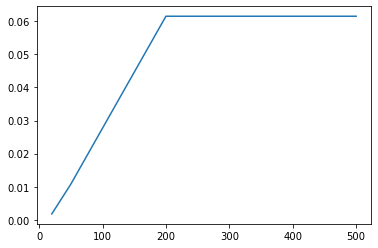

In [84]:
plt.plot(k, rec_at_k)

plt.show()

В данном случае оптимальным является k=200 т.к. дальше recall перестает расти

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [85]:
n_items_before = data_train_lvl_2['item_id'].nunique()

data_train_lvl_2 = prefilter_items(data_train_lvl_2, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_2['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 27649 to 5001


In [86]:
recommender = MainRecommender(data_train_lvl_2)

In [94]:
data_train_lvl_2 = data_train_lvl_2.astype({'user_id': 'int32','basket_id': 'int64','day': 'int32','item_id': 'int32','quantity': 'int32','user_id': 'int32',})

In [96]:
def purchase_per_month(data):
    values = {}
    df = data.drop_duplicates(['basket_id'])
    for user in data['user_id']:
        values[user] = df.loc[df['user_id'] == user]['basket_id'].count() / 4
        
    for user in values.keys():
        data.loc[data_train_lvl_2['user_id'] == user, 'pur_per_month'] = values[user]
    return data

In [97]:
def sells_per_month(data):
    values = {}
    df = data
    for item in data['item_id']:
        values[item] = df.loc[df['item_id'] == item]['basket_id'].count() * df.loc[df['item_id'] == item]['quantity'].sum() / 4
        
    for item in values.keys():
        data.loc[data_train_lvl_2['item_id'] == item, 'sell_per_month'] = values[item]
    return data

In [98]:
data_train_lvl_2 = purchase_per_month(data_train_lvl_2)

In [99]:
data_train_lvl_2 = sells_per_month(data_train_lvl_2)

In [100]:
data_train_lvl_2.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price,pur_per_month,sell_per_month
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0,2.50,1.0,600.0
2107473,2021,40618753059,594,1019142,2,5.00,443,-1.98,101,86,0.0,0.0,2.50,1.0,30.0
2107476,2021,40618753059,594,9835223,1,9.27,443,-3.63,101,86,0.0,0.0,9.27,1.0,304.0
2108010,1753,40618809138,594,999999,1,29.99,345,0.00,8,86,0.0,0.0,29.99,5.0,91870339.0
2108685,2120,40629515323,594,999999,1,2.09,136,0.00,830,86,0.0,0.0,2.09,2.5,91870339.0


In [102]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']
    
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['drop'] = 1  # фиктивная пересенная

targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [103]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

C:\Users\stroganov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\stroganov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\stroganov\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:863: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


In [104]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']
    
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['drop'] = 1  # фиктивная пересенная

targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

X_val = targets_lvl_2.drop('target', axis=1)
y_val = targets_lvl_2[['target']]

cat_feats = X_val.columns[2:].tolist()
X_val[cat_feats] = X_val[cat_feats].astype('category')

In [109]:
recommend_list= []
mean_precision_at_k = []
for user, bought_list in zip(result_lvl_1['user_id'],result_lvl_1['actual']):
    recommend_list = recommender.get_similar_items_recommendation(user, N=200)
    mean_precision_at_k.append(precision_at_k(recommend_list, bought_list, k=200))
    
print(f'Средний precision_at_k равен {np.array(mean_precision_at_k).mean()}')

Средний precision_at_k равен 0.03715413184772516


In [110]:
print(f'Средний precision_at_k равен {precision_at_k(train_preds,y_val, k=200) / 10000}')

Средний precision_at_k равен 0.0350165


precision_at_k уменьшился

### Финальный проект

Мы уже прошли всю необходимую теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - money precision@5. Порог для уcпешной сдачи проекта money precision@5 > 20%

Бизнес ограничения в топ-5 товарах:
- Для каждого юзера 5 рекомендаций (иногда модели могут возвращать < 5)
- **2 новых товара** (юзер никогда не покупал)
- **1 дорогой товар, > 7 долларов**
- **Все товары из разных категорий** (категория - department)  
- **Стоимость каждого рекомендованного товара > 1 доллара**  

- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и .csv файл с рекомендациями. В .csv файле 2 столбца: user_id - (item_id1, item_id2, ..., item_id5)